# CIR model to somulate changes in Intert rates and Liability hedging.
The conx Ingersoll Ross model is used to model the dyanamics of interest rayes and is an extension of the popular Vasicek Model to prebent negative interest rates
$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t} dW_t$$
As for the valuables, $a$ means that how fast the $r_t$ go close to the long-term interest rate which is denoted by b.

## Short rate vs Annualized one

In [16]:
1 + 1*0.5

1.5

In [17]:
1 + 1*0.5+(1 + 1*0.5)*0.5

2.25

In [18]:
1 + 1 * 0.25 + (1 + 1 * 0.25)*0.25 + (1 + 1 * 0.25 + (1 + 1 * 0.25)*0.25)*0.25 + (1 + 1 * 0.25 + (1 + 1 * 0.25)*0.25 + (1 + 1 * 0.25 + (1 + 1 * 0.25)*0.25)*0.25)*0.25

2.44140625

In general, if we compound everu 1/N of a year (i.e. N times a year) we get:
$$\left(1+\frac{r}{N}\right)^N$$

In [19]:
(1+1/2)**2

2.25

In [20]:
(1+1/4)**4

2.44140625

In [21]:
(1+1/100)**100

2.7048138294215285

When N gets so large, the below holds:
$$1 + r_{\text{annual}} = e^{r_{\text{inst}}}$$
$$\therefore, r_{\text{annual}} = e^{r_{\text{inst}}} - 1$$
$$\therefore, r_{\text{inst}} = \ln{(1 + r_{\text{annual}})}$$

In [34]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def inst_to_ann(r):
    """
    A convert short rate to an annualized rate
    """
    return np.expm1(r)
def ann_to_inst(r):
    """
    An annualized rate to a convert short rate
    """
    return np.log1p(r)

In [27]:
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    """
    Implement the CIR model for Interest date
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/ steps_per_year

    num_steps = int(n_years*steps_per_year)+1
    shock = np.random.normal(0, scale = np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0]=r_0

    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a *(b-r_t) * dt+ sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)

    return pd.DataFrame(data=inst_to_ann(rates), index = range(num_steps))

In [28]:
%matplotlib inline

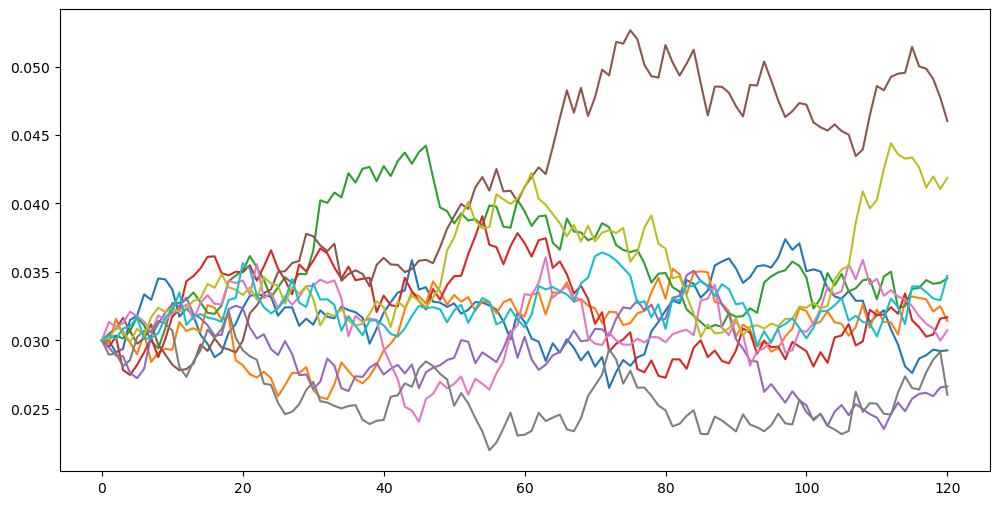

In [33]:
cir(n_scenarios=10, sigma=0.02).plot(figsize = (12,6),legend = False)
plt.show()

In [37]:
def show_cir(r_0 = 0.03, a=0.5, b = 0.03, sigma=0.05, n_scenarios=5):
    cir(r_0 = r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend = False, figsize=(12,5))
    plt.show()

control= widgets.interactive(show_cir,
                            r_0 = (0,0.15, 0.01),
                            a = (0,1,0.1),
                            b = (0, 0.15, 0.01),
                            sigma=(0, 0.1, 0.01),
                            n_scenarios = (1,100)
                            )
display(control)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated nterest ratem using the following equations.

$$
P(t, T) = A(t, T) e^{-B(t, T) r_t}
$$

where

$$
A(t, T)
=
\left(
    \frac{2 h e^{(a + h) t/2}}
         {2 h + (a + h)\left(e^{th} - 1\right)}
\right)^{\frac{2 a b}{\sigma^2}}
$$
$$
B(t, T)
=
\frac{
    2\left(e^{th} - 1\right)
}{
    2 h + (a + h)\left(e^{th} - 1\right)
}
$$
$$
h = \sqrt{a^2 + 2\sigma^2},
\qquad
\tau = T - t
$$

In [ ]:
import math
def updated_cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    """
    Implement the CIR model for Interest date
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/ steps_per_year
    num_steps = int(n_years*steps_per_year)+1
    
    shock = np.random.normal(0, scale = np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0]=r_0

    h = math.sqrt(a**2 + 2 * sigma**2)
    prices = np.empty_like(shock)

    def price(ttm, r):
        _A = ((2*h*math.exp((a+h)*ttm/2))/(2*h + (a+h)*(math.exp(h*ttm)-1)))**(2*a*b/(sigma**2))
        _B = (2*(math.exp(ttm * h)-1))/(2*h + (a+h)*(math.exp(ttm*h)-1))
        _P = _A * np.exp(- _B*r)
        return _P
    prices[0] = price(n_years, r_0)

    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a *(b-r_t) * dt+ sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index = range(num_steps))
    prices = pd.DataFrame(data=prices, index = range(num_steps))

    return rates, prices

In [ ]:
def show_cir_prices(r_0 = 0.03, a=0.5, b = 0.03, sigma=0.05, n_scenarios=5):
    updated_cir(r_0 = r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend = False, figsize=(12,5))
    plt.show()

control= widgets.interactive(show_cir_prices,
                            r_0 = (0,0.15, 0.01),
                            a = (0,1,0.1),
                            b = (0, 0.15, 0.01),
                            sigma=(0, 0.1, 0.01),
                            n_scenarios = (1,100)
                            )
display(control)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [54]:
a_0 = 0.75
rates, bond_prices = updated_cir(n_years= 10, r_0 = 0.03, b=0.03, n_scenarios=10)
liability = bond_prices
zcbond_10 = pd.Series(data = [1], index = [10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (rates/12+1).cumprod()


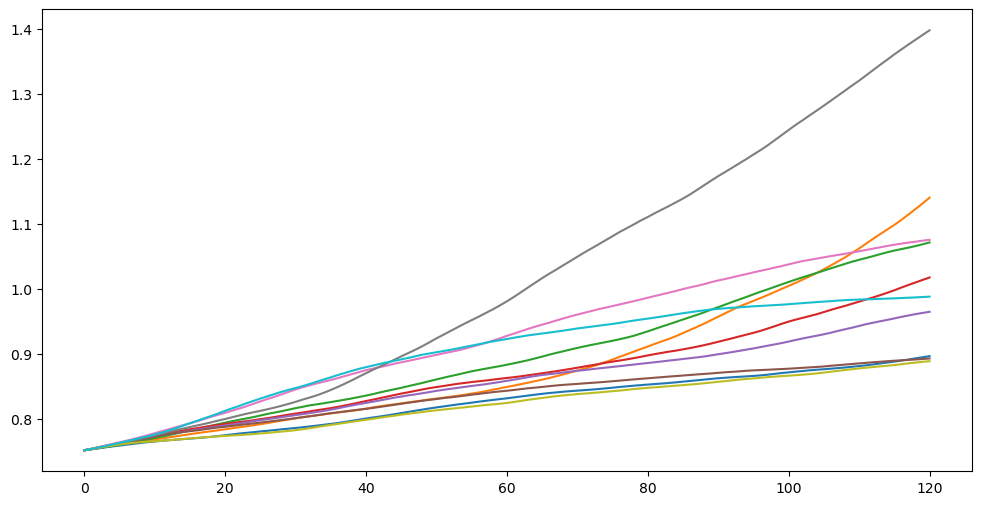

In [55]:
av_cash.plot(legend = False, figsize=(12,6))
plt.show()

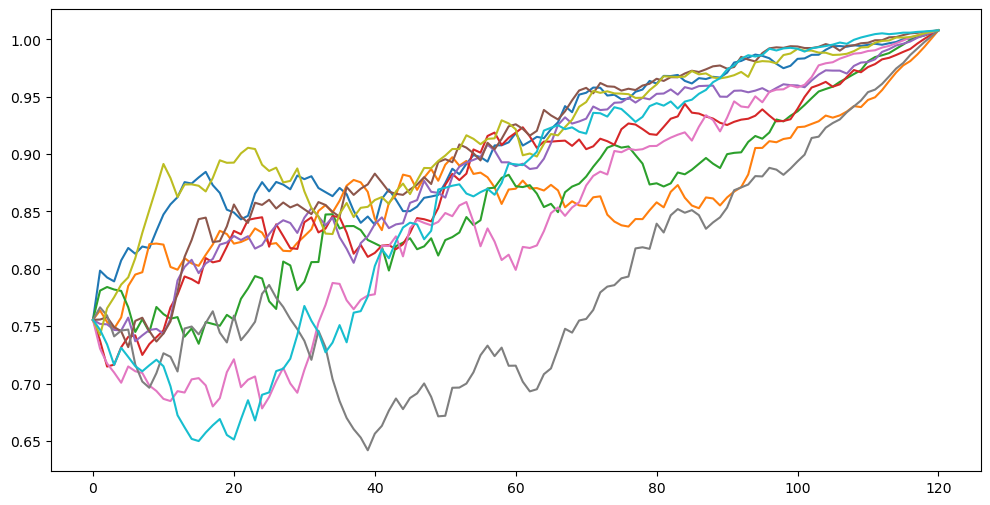

In [56]:
av_zc_bonds.plot(legend = False, figsize=(12,6))
plt.show()

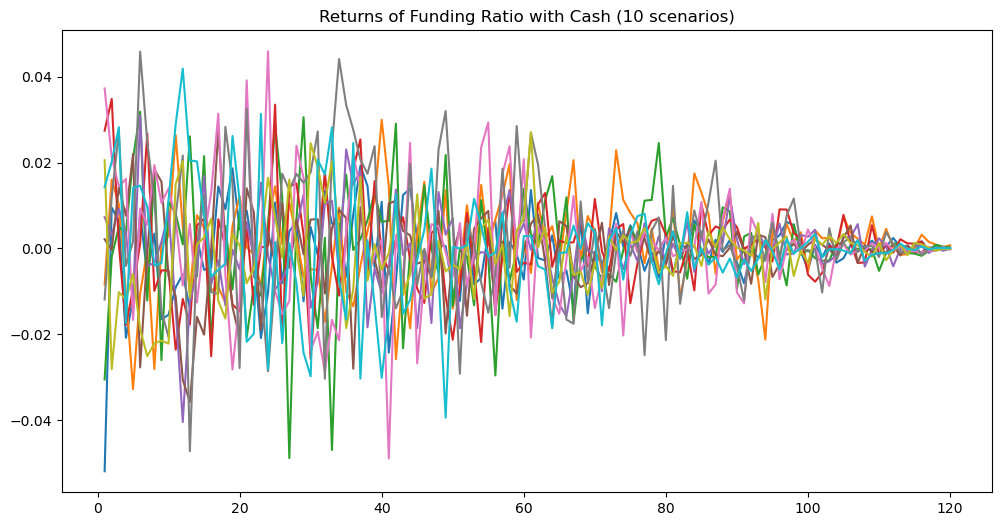

In [59]:
(av_cash/liability).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

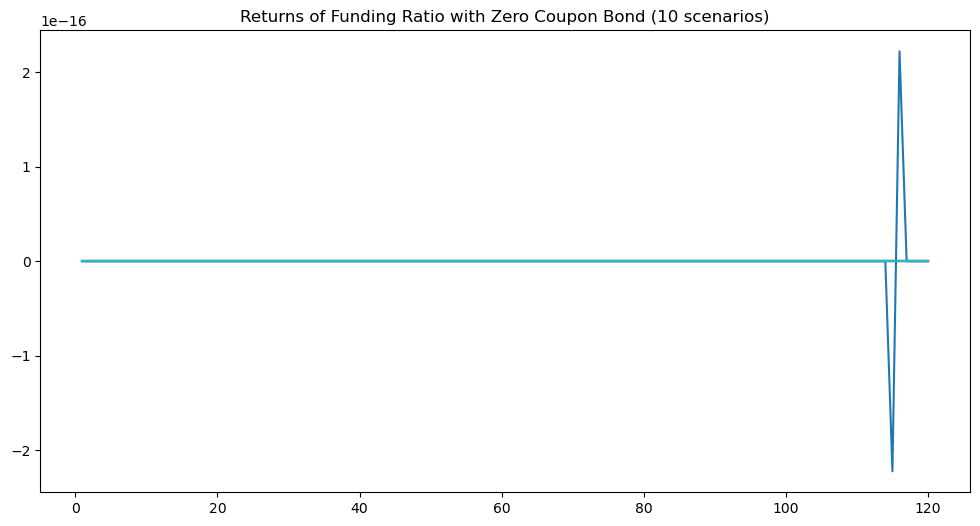

In [60]:
(av_zc_bonds/liability).pct_change().plot(title='Returns of Funding Ratio with Zero Coupon Bond (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

In [70]:
a_0 = 0.75
rates, bond_prices = updated_cir(n_scenarios= 10000, r_0 = 0.03, b = 0.03)
liability = bond_prices
zcbond_10 = pd.Series(data = [1], index = [10])
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (1 + rates/12).cumprod()

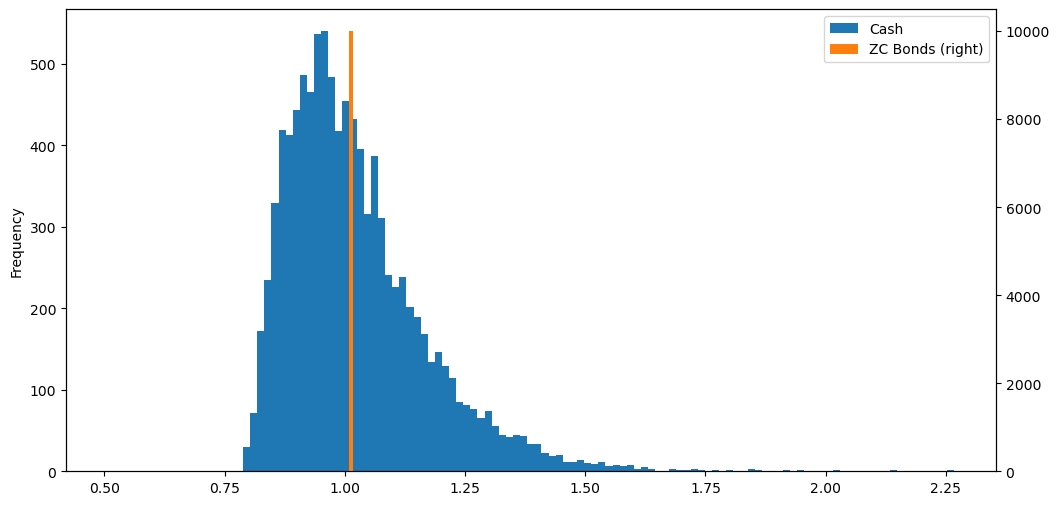

In [71]:
tfr_cash = av_cash.iloc[-1]/liability.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liability.iloc[-1]
ax = tfr_cash.plot.hist(label = "Cash", figsize=(12,6), bins = 100, legend=True)
tfr_zc_bonds.plot.hist(ax = ax, label="ZC Bonds", bins = 100, legend=True, secondary_y = True)
plt.show()